In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os

from tensorflow import keras
from keras import models, layers, optimizers

# Preprocessing Data

In [55]:
fsa_chosen = "L9G"
years = ['2018', '2019', '2020', '2021', '2022', '2023']
months = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']

# Setting up paths for data loading
dirs_x_y_input = os.path.join("..", "data", "X_Y_Inputs")
file_path_x = os.path.join(dirs_x_y_input, "X_df_"+fsa_chosen+".csv")
file_path_y = os.path.join(dirs_x_y_input, "Y_df_"+fsa_chosen+".csv")

# Load the data
X_df_cnn = pd.read_csv(file_path_x)
Y_df_cnn = pd.read_csv(file_path_y)

# Drop unrequired columns
drop_list = [
    "Rel Hum (%)",
    "Wind Spd (km/h)",
    "DATE",
]
feature_columns = X_df_cnn.columns.to_list()
for col in drop_list:
    feature_columns.remove(col)

# Create dataframe without hummus and spread
data = X_df_cnn[feature_columns]

KeyboardInterrupt: 

In [3]:
window_size = 168  # Last 168 hours (one week)
forecast_horizon = 24  # Next 24 hours

X_data = []
y_data = []

# Create input-output pairs using a sliding window
for i in range(len(data) - window_size - forecast_horizon + 1):
    X_data.append(data.iloc[i:i + window_size].values)  # Collect 168 hours of feature data
    # Collect the next 24 hours of output data from Y_df
    y_data.append(Y_df_cnn.iloc[i + window_size:i + window_size + forecast_horizon].values.flatten())  # Flatten to ensure it's 1D

# Convert to numpy arrays
X_data, y_data = np.array(X_data, dtype=np.float32), np.array(y_data, dtype=np.float32)
X_data = np.expand_dims(X_data, axis=-1)

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, shuffle=False, random_state=42)

# Set up the model structure

In [4]:
# Better model
model = models.Sequential(
    [
        layers.Input(shape=X_train.shape[-3:]),
        # Convolutional layers 1-3
        layers.Conv2D(
            filters=32, kernel_size=(3, 3), padding="same", activation="relu"
        ),
        layers.Conv2D(
            filters=32, kernel_size=(3, 3), padding="same", activation="relu"
        ),
        layers.Conv2D(
            filters=32, kernel_size=(3, 3), padding="same", activation="relu"
        ),
        layers.MaxPool2D(
            pool_size=(1, 2)
        ),  # Keep the width the same size, pool the height
        # Convolutional layers 4-6
        layers.Conv2D(
            filters=64, kernel_size=(3, 3), padding="same", activation="relu"
        ),
        layers.Conv2D(
            filters=64, kernel_size=(3, 3), padding="same", activation="relu"
        ),
        layers.Conv2D(
            filters=64, kernel_size=(3, 3), padding="same", activation="relu"
        ),
        layers.MaxPool2D(pool_size=(1, 2)),
        # Convolutional layers 7-9
        layers.Conv2D(
            filters=128, kernel_size=(3, 3), padding="same", activation="relu"
        ),
        layers.Conv2D(
            filters=128, kernel_size=(3, 3), padding="same", activation="relu"
        ),
        layers.Conv2D(
            filters=128, kernel_size=(3, 3), padding="same", activation="relu"
        ),
        layers.MaxPool2D(pool_size=(1, 2)),
        # Flatten the layers to feed into dense network
        layers.Flatten(),
        # Add dense layers
        layers.Dense(128, activation="relu"),
        layers.Dense(24),  # This is the output layer, we are predicting 24 hours!!!!!
    ]
)

# Customizing the Adam optimizer
optimizer = optimizers.Adam(
    # learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07
)

# Compile the model
model.compile(optimizer=optimizer, loss=keras.losses.Huber(), metrics=["mae"])

# Train the model

In [6]:
# Train the model
history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.2)

Epoch 1/5
 481/1048 ━━━━━━━━━━━━━━━━━━━━ 6:04 643ms/step - loss: 2681.8440 - mae: 2682.3440

KeyboardInterrupt: 

# Save the Model

In [5]:
model_dir = os.path.join("..", "models", "cnn_best_model.keras")
model.save(model_dir)

# Cool Prediction stuff

In [6]:
# Make predictions
model_dir = os.path.join("..", "models", "cnn_best_model_2.keras")
model = models.load_model(model_dir)

Y_pred = model.predict(X_test)  # Predict on X_test

# Convert predictions to a DataFrame
Y_pred_df = pd.DataFrame(Y_pred)

328/328 ━━━━━━━━━━━━━━━━━━━━ 42s 124ms/step


# Cool Plotting Stuff that needs History

In [ ]:

# Extract loss and MAE values from the history object
loss = history.history['loss']
mae = history.history['mae']
val_loss = history.history['val_loss']  # Validation loss
val_mae = history.history['val_mae']    # Validation MAE

# Plot the training and validation loss
plt.figure(figsize=(12, 6))

# Plot for loss
plt.subplot(1, 2, 1)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot for MAE
plt.subplot(1, 2, 2)
plt.plot(mae, label='Training MAE')
plt.plot(val_mae, label='Validation MAE')
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()

# Model Evaluation

In [7]:
#Evaluate the model
print(f'##Model Evaluation##')
# X_test = np.expand_dims(X_test, axis=-1)
test_loss, test_mae = model.evaluate(np.expand_dims(X_test, axis=-1), y_test)  # Use X_test and y_test
print(f'Test Loss: {test_loss:.4f}')
print(f'Test MAE: {test_mae:.4f}')

# Function to calculate Mean Absolute Percentage Error
def mean_absolute_percentage_error(y_true, Y_pred):
    y_true, Y_pred = np.array(y_true), np.array(Y_pred)
    return np.mean(np.abs((y_true - Y_pred) / y_true)) * 100

mape = mean_absolute_percentage_error(y_test, Y_pred)
print("MAPE = " + str(round(mape, 3)) + "%.")

##Model Evaluation##
328/328 ━━━━━━━━━━━━━━━━━━━━ 41s 123ms/step - loss: 706.7864 - mae: 707.2863
Test Loss: 895.8884
Test MAE: 896.3882
MAPE = 9.111%.


# Plotting

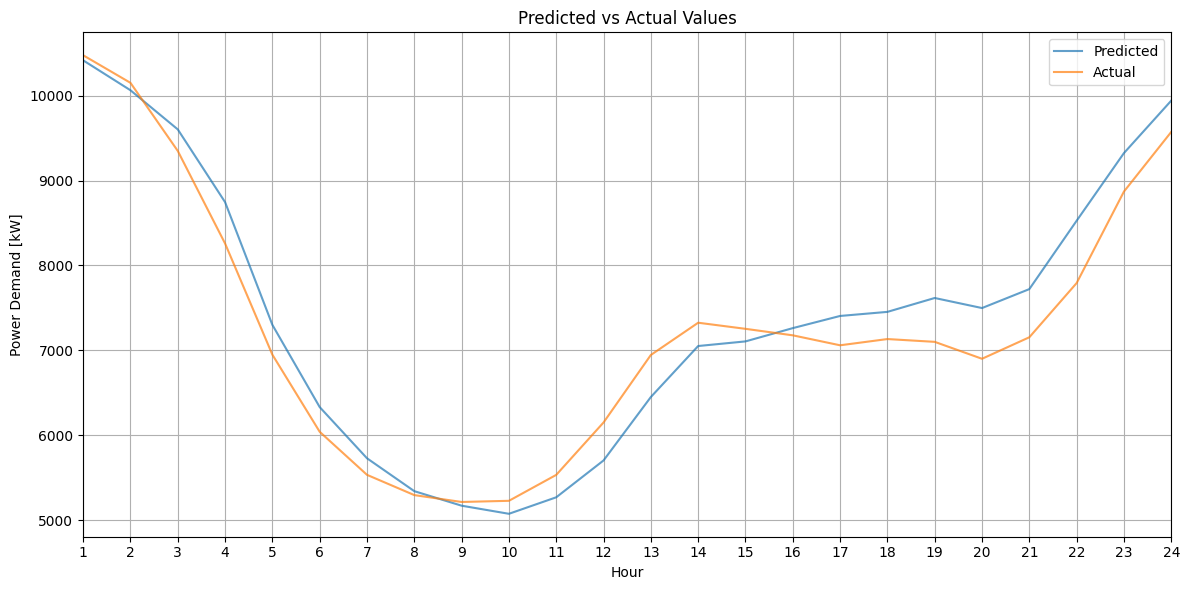

In [56]:
random_test_day = 80

# Create a simple plot comparing predictions vs actual values
plt.figure(figsize=(12, 6))
times = np.arange(1,25,1)
plt.plot(times, Y_pred[random_test_day], label='Predicted', alpha=0.7)
plt.plot(times, y_test[random_test_day], label='Actual', alpha=0.7)
plt.title('Predicted vs Actual Values')
plt.xlabel('Hour')
plt.ylabel('Power Demand [kW]')

plt.xlim(1, 24)
plt.xticks(np.arange(1, 25, 1))

plt.legend()
plt.grid(True)
plt.tight_layout()
